<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-14.1" data-toc-modified-id="Figure-14.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 14.1</a></span></li><li><span><a href="#the-FFT-based-hilbert-transform" data-toc-modified-id="the-FFT-based-hilbert-transform-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>the FFT-based hilbert transform</a></span></li><li><span><a href="#Figure-14.2" data-toc-modified-id="Figure-14.2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 14.2</a></span></li><li><span><a href="#Figure-14.3" data-toc-modified-id="Figure-14.3-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 14.3</a></span></li><li><span><a href="#Figure-14.4" data-toc-modified-id="Figure-14.4-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 14.4</a></span></li><li><span><a href="#Figure-14.5" data-toc-modified-id="Figure-14.5-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 14.5</a></span></li><li><span><a href="#Figure-14.6" data-toc-modified-id="Figure-14.6-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Figure 14.6</a></span></li><li><span><a href="#Figure-14.7" data-toc-modified-id="Figure-14.7-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Figure 14.7</a></span></li><li><span><a href="#Figure-14.8" data-toc-modified-id="Figure-14.8-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Figure 14.8</a></span></li><li><span><a href="#Figure-14.9" data-toc-modified-id="Figure-14.9-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Figure 14.9</a></span></li><li><span><a href="#Figure-14.10" data-toc-modified-id="Figure-14.10-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Figure 14.10</a></span></li><li><span><a href="#Figure-14.12" data-toc-modified-id="Figure-14.12-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Figure 14.12</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 14
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import signal as sig
from scipy.stats.mstats import zscore
from time import time as tm

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 14.1

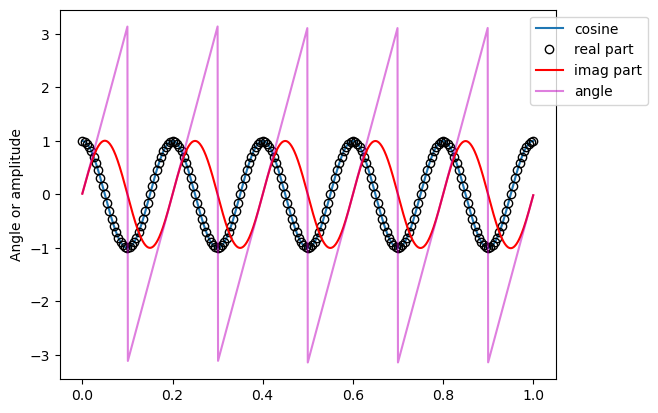

In [4]:
#create cosine
time = np.arange(0,1+0.001,0.001)
cosine = np.cos(2 * np.pi * 5 * time)

plt.plot(time,cosine)
plt.plot(time[::5],np.real(sig.hilbert(cosine[::5])),'ko',markerfacecolor='none') # plot every 5th point because of overlap
plt.plot(time,np.imag(sig.hilbert(cosine)),'r')
plt.plot(time,np.angle(sig.hilbert(cosine)),'m', alpha=0.5)

plt.ylabel("Angle or amplitude")
_=plt.legend(['cosine','real part','imag part','angle'],bbox_to_anchor=[1.2,1])

## the FFT-based hilbert transform

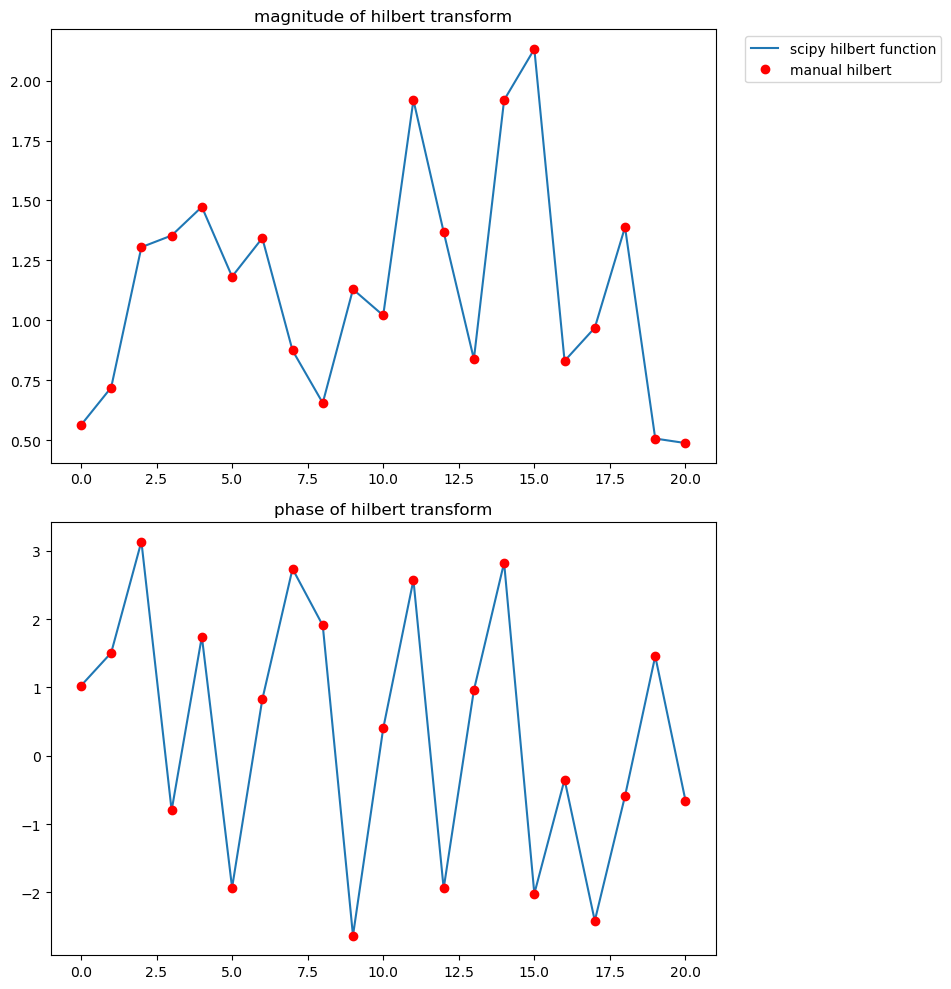

In [5]:
# generate random numbers
n = 21
randomnumbers = np.random.randn(21)

# take FFT
f = np.fft.fft(randomnumbers)

# create a copy that is multiplied by the complex operator
complexf = 1j*f

# find indices of positive and negatice frequencies
posF = np.arange(1,np.floor(n/2.) + (n%2)).astype(int)
negF = np.arange(np.ceil(n/2.) + (~n%2),n).astype(int)


# rotate Fourier coefficients
# (note 1: this works by computing the iAsin(2pft) component, i.e., the phase quadrature)
# (note 2: positive frequencies are rotated counter-clockwise; negative frequencies are rotated clockwise)
f[posF] = f[posF] + -1j*complexf[posF];
f[negF] = f[negF]+  1j*complexf[negF];
# The next two lines are an alternative and slightly faster method. 
# The book explains why this is equivalent to the previous two lines.
# f(posF) = f(posF)*2;
# f(negF) = f(negF)*0;

# take inverse FFT
hilbertx = np.fft.ifft(f)

# compare with scipy function hilbert
hilbertm = sig.hilbert(randomnumbers)

# plot results
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(np.abs(hilbertm))
plt.plot(np.abs(hilbertx),'ro')
plt.legend(["scipy hilbert function","manual hilbert"],bbox_to_anchor = [1.35,1])
plt.title("magnitude of hilbert transform")

plt.subplot(2,1,2)
plt.plot(np.angle(hilbertm))
plt.plot(np.angle(hilbertx),'ro')
plt.title("phase of hilbert transform")

plt.tight_layout()

## Figure 14.2

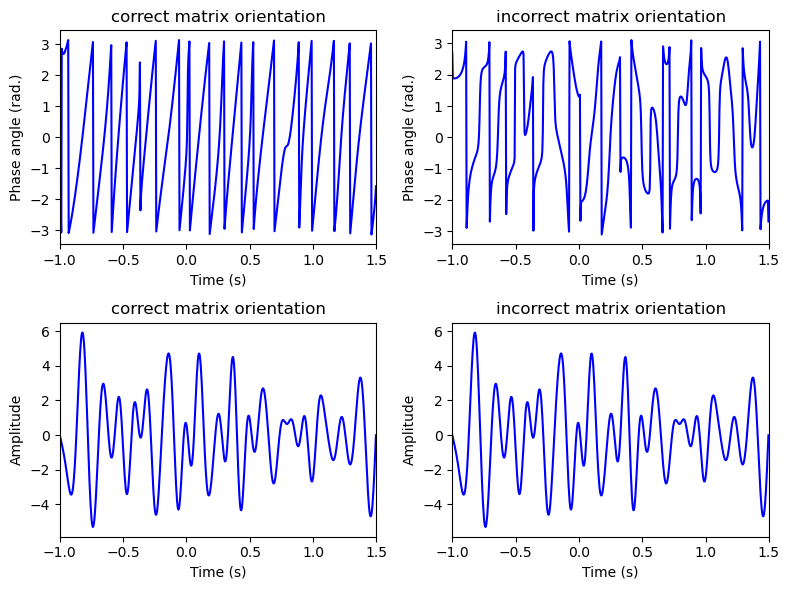

In [6]:
# first, filter data (filter mechanisms will be explained more below; for now, focus on 
# using the phases from the Hilbert transform to test whether the matrix input was correct)

nyquist = srate//2
lower_filter_bound = 4  # Hz
upper_filter_bound = 10 # Hz
transition_width = 0.2
filter_order = 3 * srate // lower_filter_bound + 1

# create the filter shape (this is explained more in the text around figure 14.4)
ffrequencies = np.array([0, (1-transition_width) * lower_filter_bound, 
                        lower_filter_bound, upper_filter_bound, 
                         (1 + transition_width)* upper_filter_bound, nyquist]) / nyquist

idealresponse = np.array([0,0,1,1,0,0])
filterweights = sig.firls(filter_order,ffrequencies,idealresponse)

# apply the filter kernal to the data to obtain the band-pass filtered signal
filtered_data = np.zeros([nbchan,pnts])

for chani in range(nbchan):
    filtered_data[chani,:] = sig.filtfilt(filterweights,1,data[0,chani,:])

#  apply hilbert transform in correct and incorrect orientations
hilbert_oops = sig.hilbert(filtered_data, axis=0);
hilbert_yes  = sig.hilbert(filtered_data,axis=1); # time should be in the first dimension. 

#  Note that the output of the hilbert transform is transposed to bring us back to an electrode X time matrix.

plt.figure(figsize=[8,6])

plt.subplot(2,2,1)
plt.plot(times,np.angle(hilbert_yes[0,:]),'b');
plt.title('correct matrix orientation')
plt.xlabel('Time (s)'), plt.ylabel('Phase angle (rad.)')
gca =plt.gca()
plt.setp(gca,'xlim',[-1, 1.5])

plt.subplot(2,2,2)
plt.plot(times,np.angle(hilbert_oops[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (s)'), plt.ylabel('Phase angle (rad.)')
gca =plt.gca()
plt.setp(gca,'xlim',[-1, 1.5])

plt.subplot(2,2,3)
plt.plot(times,np.real(hilbert_yes[0,:]),'b');
plt.title('correct matrix orientation')
plt.xlabel('Time (s)'), plt.ylabel('Amplitude')
gca =plt.gca()
plt.setp(gca,'xlim',[-1, 1.5])

plt.subplot(2,2,4)
plt.plot(times,np.real(hilbert_oops[0,:]),'b');
plt.title('incorrect matrix orientation')
plt.xlabel('Time (s)'), plt.ylabel('Amplitude')
gca =plt.gca()
plt.setp(gca,'xlim',[-1, 1.5])

plt.tight_layout()

## Figure 14.3

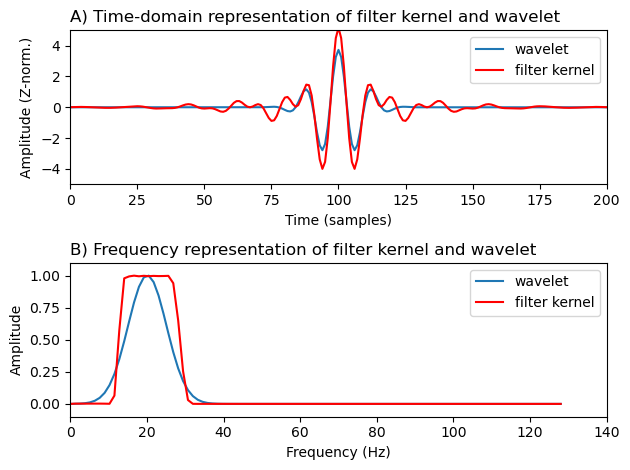

In [7]:
center_freq = 20 # in Hz
filter_frequency_spread = 6 # Hz, +/- the center frequency
wavelet_frequency_spread = 4 # number of wavelet cycles

# create wavelet...
time = np.arange(-1000/srate/10, 1000/srate/10 + 1/srate, 1/srate)
wavelet = zscore(np.exp(2 * 1j * np.pi * center_freq * time) * np.exp(-time **2 / (2 * (wavelet_frequency_spread/(2 * np.pi * center_freq)) **2)))

# and compute its power spectrum
fft_wavelet = np.abs(np.fft.fft(wavelet))
fft_wavelet /= np.max(fft_wavelet) # normalized to 1.0 for visual comparison ease
hz_wavelet = np.linspace(0,nyquist,len(time)//2 + 1)

# construct filter kernel (the mechanics of filter construction will be
# discussed in the text around figure 14.4)
transition_width = 0.2

ffrequencies   = np.array([ 0, (1-transition_width)*(center_freq-filter_frequency_spread),
                  (center_freq-filter_frequency_spread),
                  (center_freq+filter_frequency_spread),
                  (1+transition_width)*(center_freq+filter_frequency_spread),
                  nyquist ])/nyquist


idealresponse = np.array([0, 0, 1, 1, 0, 0])
filterweights = zscore(sig.firls(201,ffrequencies,idealresponse))

# also compute weights using firwin instead of fir1
filterweights1 = zscore(sig.firwin(201, [center_freq - filter_frequency_spread, 
                              center_freq + filter_frequency_spread], pass_zero=False, fs=2*nyquist))

# compute its power spectrum
fft_filtkern = np.abs(np.fft.fft(filterweights))
fft_filtkern /= np.max(fft_filtkern) #% normalized to 1.0 for visual comparison ease

fft_filtkern1 = np.abs(np.fft.fft(filterweights1))#
fft_filtkern1 /= np.max(fft_filtkern1) # normalized to 1.0 for visual comparison ease

hz_filtkern = np.linspace(0,nyquist,101) # list of frequencies in Hz corresponding to filter kernel

# plot wavelet and filter kernel
plt.subplot(2,1,1)
plt.plot(np.real(wavelet))
plt.plot(filterweights,'r')
plt.legend(["wavelet","filter kernel"])
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-5, 5])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (Z-norm.)')
plt.title('A) Time-domain representation of filter kernel and wavelet', loc='left')

# plot power spectra
plt.subplot(2,1,2)
plt.plot(hz_wavelet, fft_wavelet[:int(np.ceil(len(fft_wavelet)/2.))])
plt.plot(hz_filtkern, fft_filtkern[:int(np.ceil(len(fft_filtkern)/2.))],'r')
plt.legend(['wavelet','filter kernel'])
plt.setp(plt.gca(),'ylim',[-.1, 1.1])
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 140])
plt.ylabel('Amplitude')
plt.title('B) Frequency representation of filter kernel and wavelet', loc='left')

plt.tight_layout()

## Figure 14.4

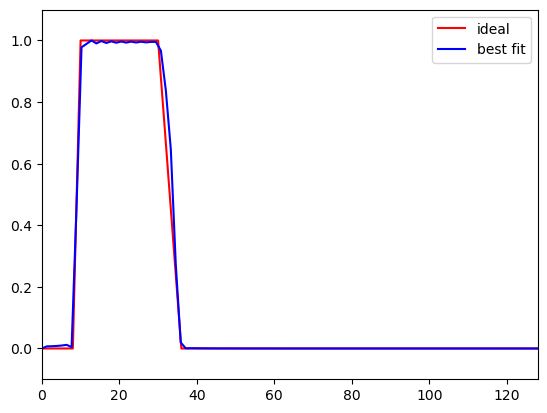

In [8]:
center_freq = 20 # in Hz
filter_frequency_spread_wide = 10 # Hz +/- center frequency

ffrequencies   = np.array([ 0,
                  (1-transition_width) * (center_freq-filter_frequency_spread_wide),
                  (center_freq-filter_frequency_spread_wide) ,
                  (center_freq+filter_frequency_spread_wide), 
                  (1+transition_width) * (center_freq+filter_frequency_spread_wide) ,
                  nyquist ])/nyquist;

idealresponse = np.array([0,0,1,1,0,0])
filterweightsW = zscore(sig.firls(201,ffrequencies,idealresponse))


plt.plot(ffrequencies*nyquist,idealresponse,'r')


fft_filtkern = np.abs(np.fft.fft(filterweightsW))
fft_filtkern = fft_filtkern/np.max(fft_filtkern) #normalized to 1 for visualization

plt.plot(hz_filtkern,fft_filtkern[:int(np.ceil(len(fft_filtkern)/2))],'b')

plt.axis([0,nyquist,-.1,1.1])
_=plt.legend(["ideal",'best fit'])

## Figure 14.5

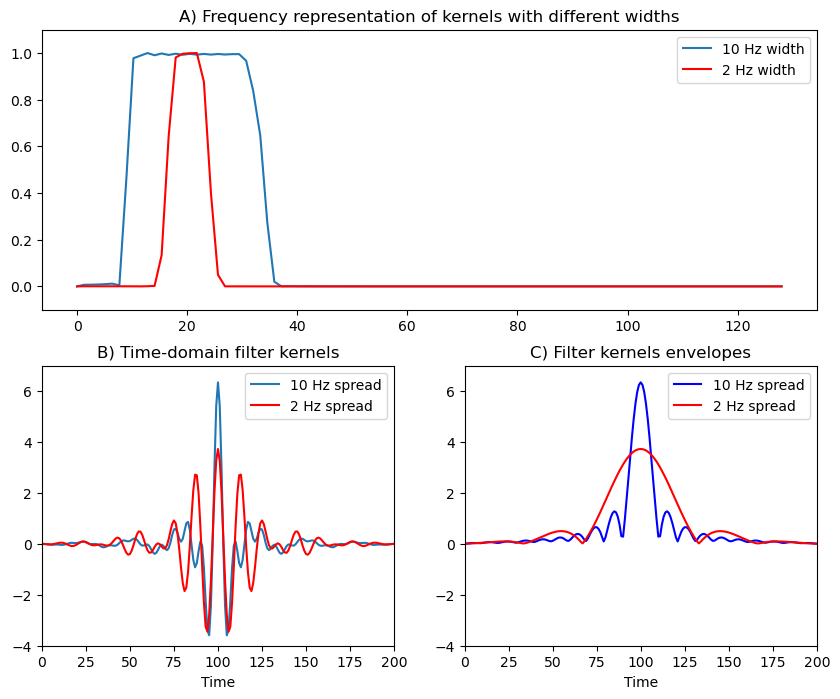

In [9]:
center_freq = 20 # in Hz
filter_frequency_spread_wide = 10 # Hz +/- the center frequency
filter_frequency_spread_naro =  2 # Hz +/- the center frequency

# construct filter kernels
ffrequencies   = np.array([ 0, 
                  (1-transition_width)*(center_freq-filter_frequency_spread_wide), 
                  (center_freq-filter_frequency_spread_wide),
                  (center_freq+filter_frequency_spread_wide),
                  (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                  nyquist ])/nyquist
idealresponse  = np.array([ 0, 0, 1, 1, 0, 0, ])

filterweightsW = zscore(sig.firls(201,ffrequencies,idealresponse))

ffrequencies   = np.array([ 0,
                  (1-transition_width)*(center_freq-filter_frequency_spread_naro),
                  (center_freq-filter_frequency_spread_naro),
                  (center_freq+filter_frequency_spread_naro),
                  (1+transition_width)*(center_freq+filter_frequency_spread_naro),
                  nyquist ])/nyquist;

filterweightsN = zscore(sig.firls(201,ffrequencies,idealresponse))

plt.figure(figsize=(10,8))
#plt.subplots_adjust()
plt.subplot(2,1,1)
fft_filtkern  = np.abs(np.fft.fft(filterweightsW))
fft_filtkern  = fft_filtkern/np.max(fft_filtkern) # normalized to 1.0 for visual comparison ease
plt.plot(hz_filtkern,fft_filtkern[:int(np.ceil(len(fft_filtkern)/2))])

fft_filtkern1  = np.abs(np.fft.fft(filterweightsN))
fft_filtkern1  = fft_filtkern1 / np.max(fft_filtkern1)# normalized to 1.0 for visual comparison ease
plt.plot(hz_filtkern,fft_filtkern1[:int(np.ceil(len(fft_filtkern1)/2))],'r')
plt.setp(plt.gca(),'ylim',[-.1 ,1.1])
plt.title('A) Frequency representation of kernels with different widths')
_=plt.legend(['10 Hz width','2 Hz width'])

plt.subplot(2,2,3)
plt.plot(filterweightsW)
plt.plot(filterweightsN,'r')
plt.setp(plt.gca(),'xlim',[0 ,200],'ylim',[-4 ,7])
plt.legend(['10 Hz spread','2 Hz spread'])
plt.xlabel('Time')
plt.title('B) Time-domain filter kernels')

plt.subplot(2,2,4)
plt.plot(np.abs(sig.hilbert(filterweightsW)),'b')
plt.plot(np.abs(sig.hilbert(filterweightsN)),'r')
plt.setp(plt.gca(),'xlim',[0, 200],'ylim',[-4 ,7])
plt.legend(['10 Hz spread','2 Hz spread'])
plt.title('C) Filter kernels envelopes')
_=plt.xlabel('Time')

## Figure 14.6

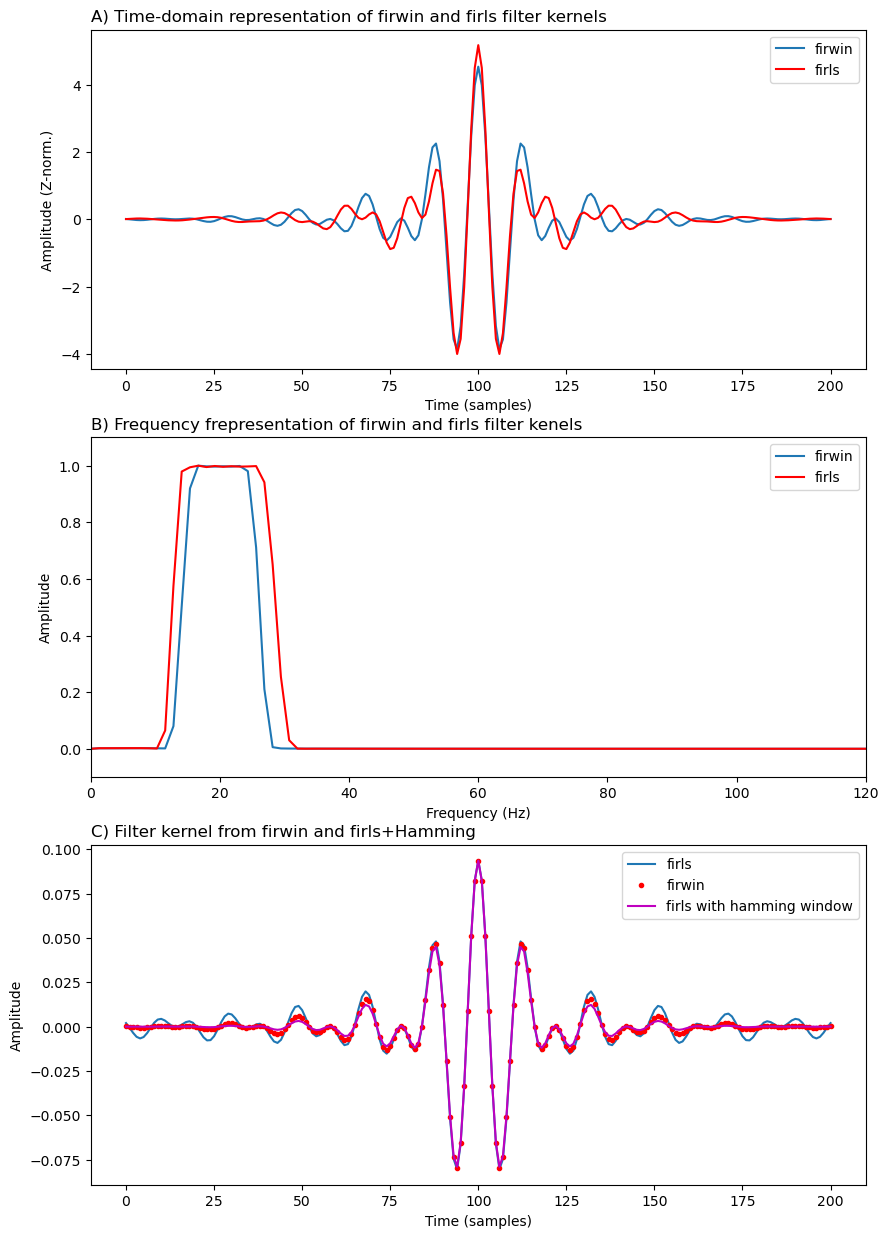

In [10]:
plt.figure(figsize=(10,15))

plt.subplot(3,1,1)

#plot wavelet and filter kernel
plt.plot(filterweights1)
plt.plot(filterweights,'r')
plt.legend(['firwin', 'firls'])
plt.setp(plt.gca(),'xlabel', 'Time (samples)', 'ylabel', 'Amplitude (Z-norm.)')
plt.title('A) Time-domain representation of firwin and firls filter kernels', loc='left')


# plot power spectra
fft_filtkern = np.abs(np.fft.fft(filterweights))
fft_filtkern /= np.max(fft_filtkern) #% normalized to 1.0 for visual comparison ease

fft_filtkern1 = np.abs(np.fft.fft(filterweights1))#
fft_filtkern1 /= np.max(fft_filtkern1) # normalized to 1.0 for visual comparison ease

plt.subplot(3,1,2)
plt.plot(hz_filtkern,fft_filtkern1[0:int(np.ceil(len(fft_filtkern1)/2))])
plt.plot(hz_filtkern,fft_filtkern[0:int(np.ceil(len(fft_filtkern)/2))],'r')
plt.legend(['firwin','firls'])
plt.setp(plt.gca(),'ylim',[-.1,1.1],'xlim',[0, 120], 'xlabel', 'Frequency (Hz)', 'ylabel', 'Amplitude')
plt.title('B) Frequency frepresentation of firwin and firls filter kenels', loc='left')

freqL = center_freq-filter_frequency_spread
freqU = center_freq+filter_frequency_spread

ffrequencies   = np.array( [ 0 ,freqL, freqL ,freqU, freqU ,nyquist ])/nyquist #transition zone of 0
filterweights = sig.firls(201,ffrequencies,idealresponse)

filterweights1 = sig.firwin(201, [center_freq - filter_frequency_spread, 
                              center_freq + filter_frequency_spread], pass_zero=False, fs=2*nyquist)

plt.subplot(3,1,3)
plt.plot(filterweights)
plt.plot(filterweights1,'r.')
plt.plot(filterweights1 * sig.hamming(len(filterweights1)),'m')
plt.title('C) Filter kernel from firwin and firls+Hamming', loc='left')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
_=plt.legend(['firls','firwin','firls with hamming window'])

## Figure 14.7

In [11]:
#to replace the use of Matlab's dsearchn() function
def dsearchn(X, p):
    disp = X - p
    return np.argmin((disp*disp))

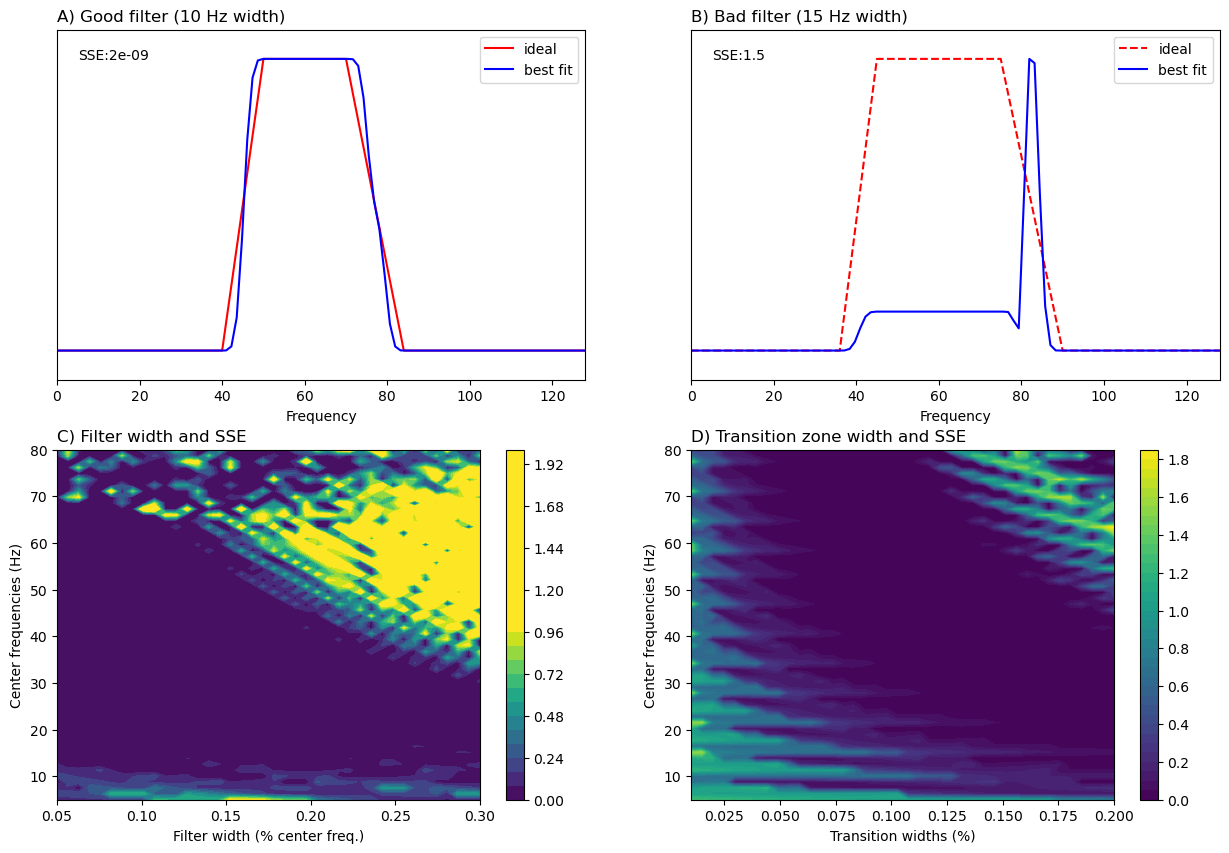

In [12]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)

center_freq = 60 # in Hz
filter_frequency_spread_wide = 10 # Hz +/- the center frequency

ffrequencies = np.array([ 0,
                  (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                  (center_freq-filter_frequency_spread_wide),
                  (center_freq+filter_frequency_spread_wide),
                  (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                  nyquist ])/nyquist

idealresponse  = np.array([ 0, 0, 1 ,1, 0, 0 ])
filterweightsW = zscore(sig.firls(201, ffrequencies, idealresponse))

plt.plot(ffrequencies*nyquist, idealresponse, 'r')

fft_filtkern= np.abs(np.fft.fft(filterweightsW))
fft_filtkern = fft_filtkern / np.max(fft_filtkern) #normalized to 1.0 for visual comparison ease
plt.plot(hz_filtkern,fft_filtkern[:int(np.ceil(len(fft_filtkern)/2))],'b')

plt.setp(plt.gca(),'ylim',[-.1,1.1],'xlim',[0, nyquist], 'xlabel', 'Frequency', 'yticks', [])
plt.legend(['ideal','best fit'])

freqsidx = [dsearchn(hz_filtkern,x) for x in ffrequencies*nyquist]
plt.text(5,1,"SSE:" + '{:.0g}'.format(np.sum((idealresponse-fft_filtkern[freqsidx])**2)))
plt.title('A) Good filter (10 Hz width)', loc='left')


plt.subplot(2,2,2)
filter_frequency_spread_wide = 15 #Hz +/-center frequency

ffrequencies = np.array([0,
                        (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                        (center_freq - filter_frequency_spread_wide),
                        (center_freq+filter_frequency_spread_wide),
                        (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                        nyquist])/nyquist

filterweightsW = zscore(sig.firls(201, ffrequencies,idealresponse))

plt.plot(ffrequencies * nyquist,idealresponse, '--r')

fft_filtkern= np.abs(np.fft.fft(filterweightsW))
fft_filtkern = fft_filtkern/np.max(fft_filtkern) #normalized to 1 for visual comparison
plt.plot(hz_filtkern,fft_filtkern[:int(np.ceil(len(fft_filtkern)/2))],'b')

plt.setp(plt.gca(),'ylim',[-.1,1.1],'xlim',[0, nyquist], 'xlabel', 'Frequency', 'yticks', [])
#plt.x
plt.legend(('ideal','best fit'))

freqsidx = [dsearchn(hz_filtkern,x) for x in ffrequencies*nyquist]

plt.text(5,1,"SSE:" + str(np.round(np.sum((idealresponse-fft_filtkern[freqsidx])**2),2)))
plt.title('B) Bad filter (15 Hz width)', loc='left')

plt.subplot(2,2,4)
centerfreqs  = np.linspace(5, 80, 60)
transwidths  = np.linspace(.01, .2, 40)
filterwidths = np.linspace(.05, .3, 40)

sse = np.zeros((len(centerfreqs), len(transwidths)))
for centfreqi in range(len(centerfreqs)):
    
    center_freq = centerfreqs[centfreqi]
    

    for transwidi in range(len(transwidths)):
        
        filter_frequency_spread_wide = center_freq*.2
        transition_width = transwidths[transwidi]
        
        ffrequencies   = np.array([ 0,
                                  (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                                  (center_freq-filter_frequency_spread_wide),
                                  (center_freq+filter_frequency_spread_wide),
                                  (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                                  nyquist ])/nyquist

        filterweightsW = zscore(sig.firls(201, ffrequencies, idealresponse))
        
        fft_filtkern   = np.abs(np.fft.fft(filterweightsW))
        fft_filtkern   = fft_filtkern / np.max(fft_filtkern) # normalized to 1.0 for visual comparison ease
        
        freqsidx = [dsearchn(hz_filtkern,x) for x in ffrequencies*nyquist]
        
        sse[centfreqi,transwidi] = np.sum((idealresponse-fft_filtkern[freqsidx])**2 )


plt.contourf(transwidths,centerfreqs, sse, 40)
plt.setp(plt.gca(),'xlabel', 'Transition widths (%)', 'ylabel', 'Center frequencies (Hz)')
plt.title('D) Transition zone width and SSE', loc='left')
plt.colorbar()

plt.subplot(2,2,3)
sse = np.zeros((len(centerfreqs),len(transwidths)));

for centfreqi in range(len(centerfreqs)):
    center_freq = centerfreqs[centfreqi]
    
    for transwidi in range(len(transwidths)):
        filter_frequency_spread_wide = center_freq*filterwidths[transwidi]
        transition_width = .2
        
        ffrequencies   = np.array([ 0,
                          (1-transition_width)*(center_freq-filter_frequency_spread_wide),
                          (center_freq-filter_frequency_spread_wide),
                          (center_freq+filter_frequency_spread_wide),
                          (1+transition_width)*(center_freq+filter_frequency_spread_wide),
                          nyquist ])/nyquist
        
        filterweightsW = zscore(sig.firls(201,ffrequencies,idealresponse));

        fft_filtkern  = np.abs(np.fft.fft(filterweightsW));
        fft_filtkern  = fft_filtkern/np.max(fft_filtkern) # normalized to 1.0 for visual comparison ease
        
        freqsidx = [dsearchn(hz_filtkern,x) for x in ffrequencies*nyquist]
        sse[centfreqi,transwidi] = np.sum( (idealresponse-fft_filtkern[freqsidx])**2)
        
        
fig = plt.contourf(filterwidths,centerfreqs,sse,30)
plt.setp(plt.gca(),'xlabel', 'Filter width (% center freq.)', 'ylabel', 'Center frequencies (Hz)')
plt.title('C) Filter width and SSE', loc='left')
plt.colorbar()
plt.clim([0,1])

## Figure 14.8

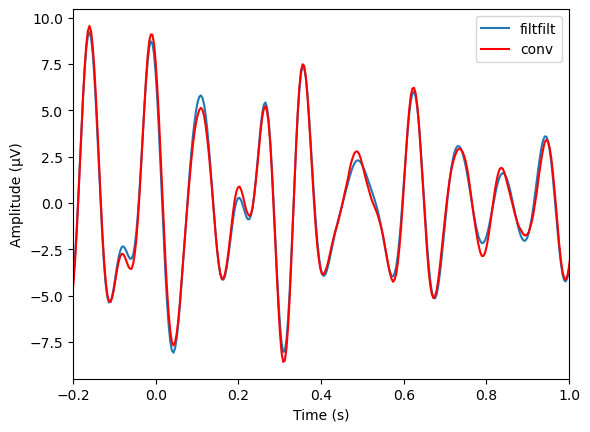

In [13]:
center_freq   = 10
freqspread    = 4 #  Hz +/- the center frequency
transwid      = .1
ffrequencies  = np.array([ 0,
                          (1-transwid)*(center_freq-freqspread),
                          (center_freq-freqspread),
                          (center_freq+freqspread),
                          (1+transwid)*(center_freq+freqspread),
                          nyquist ])/nyquist

data2filter   = data[0, 46,:]
filterweights = sig.firls(201,ffrequencies,idealresponse) # recompute without z-scoring

filter_result = sig.filtfilt(filterweights,1,data2filter)
convol_result = np.convolve(data2filter,filterweights,'same')# could also use ifft(fft(data2filter...


plt.plot(times,filter_result)
plt.plot(times,convol_result,'r')
plt.setp(plt.gca(),'xlabel', 'Time (s)', 'ylabel', 'Amplitude (μV)', 'xlim', [-.2, 1]) # zoom-in
_=plt.legend(['filtfilt','conv'])

## Figure 14.9

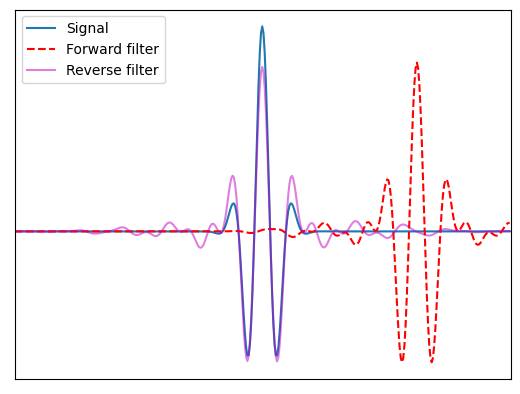

In [14]:
center_freq = 10 # in Hz
nyquist     = srate/2.;

# create short sine wave
time    = np.arange(-2000/srate/10,2000 / srate/10 + 1/srate,1/srate)
wavelet = np.cos(2*np.pi*center_freq*time) * np.exp(-time**2 / (2* (3 / (2*np.pi*center_freq)) **2));


freqspread = 4 # Hz +/- the center frequency
transwid   = .1

# construct filter kernels
ffrequencies  = np.array([ 0 ,
                 (1-transwid)*(center_freq-freqspread),
                 (center_freq-freqspread) ,
                 (center_freq+freqspread),
                 (1+transwid)*(center_freq+freqspread),
                 nyquist ])/nyquist;
idealresponse = np.array([ 0 ,0 ,1, 1, 0, 0 ])
filterweights = sig.firls(251,ffrequencies,idealresponse);


forward_filt = sig.lfilter(filterweights,1,wavelet)
reverse_filt = sig.lfilter(filterweights,1,forward_filt[::-1])
final_filt_result = reverse_filt[::-1] # must reverse time again!

plt.plot(wavelet)
plt.plot(forward_filt,'--r')
plt.plot(reverse_filt,'m', alpha=0.5)

plt.setp(plt.gca(),'xlim',[0, len(wavelet)], 'xticks', [], 'yticks', [])
plt.legend(['Signal','Forward filter','Reverse filter'])

## Figure 14.10

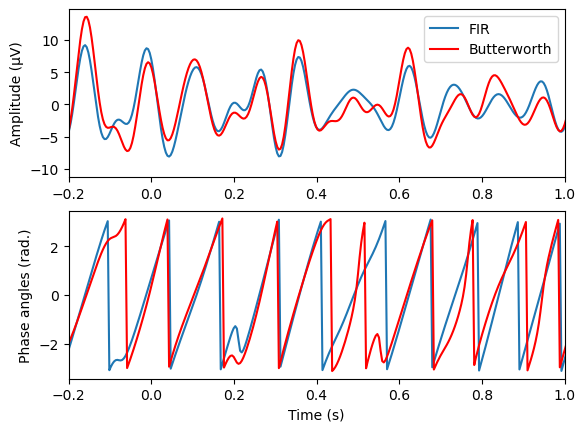

In [15]:
# 5 th order butterworth filter
butterB,butterA = sig.butter(4,np.array([(center_freq-filter_frequency_spread),
                                         (center_freq+filter_frequency_spread)])/nyquist,btype='bandpass');
butter_filter = sig.filtfilt(butterB,butterA,data2filter,padlen=150);


plt.subplot(2,1,1)

# plot real part of the filtered signal
plt.plot(times,filter_result)
plt.plot(times,butter_filter,'r')
plt.setp(plt.gca(),'xlim',[-.2, 1], 'ylabel', 'Amplitude (μV)')
plt.legend(['FIR','Butterworth'])

# now plot phases
plt.subplot(2,1,2)
plt.plot(times, np.angle(sig.hilbert(filter_result)))
plt.plot(times, np.angle(sig.hilbert(butter_filter)),'r')
_=plt.setp(plt.gca(),'xlim',[-.2, 1], 'xlabel', 'Time (s)', 'ylabel', 'Phase angles (rad.)')

## Figure 14.12

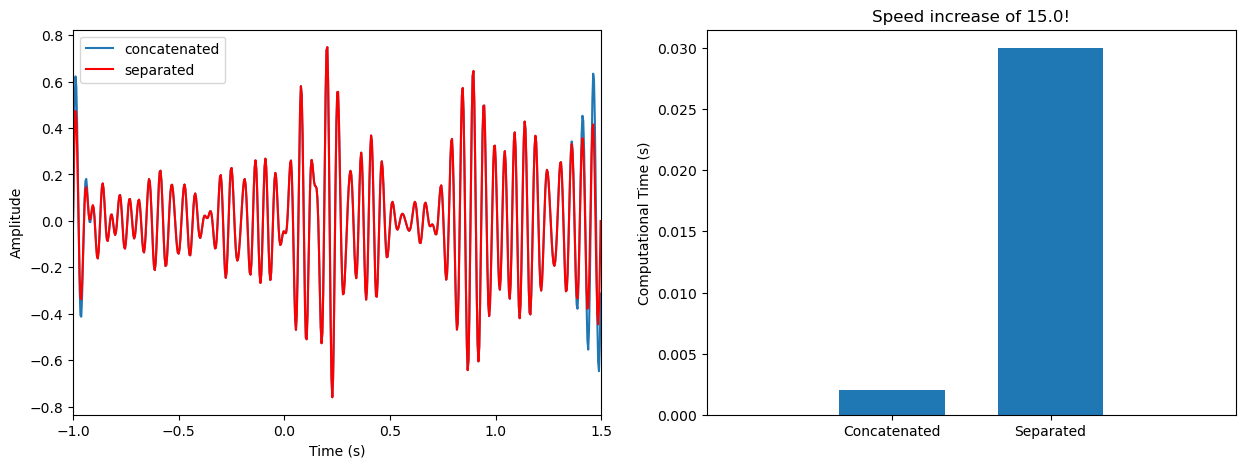

In [16]:
elap_time = np.array([0, 0])
num_iter  = 500

freqspread  =  4 # Hz +/- the center frequency
center_freq = 20.
transwid    = .15

# construct filter kernels
ffrequencies  = np.array([ 0,
                          (1-transwid)*(center_freq-freqspread),
                          (center_freq-freqspread) ,
                          (center_freq+freqspread) ,
                          (1+transwid)*(center_freq+freqspread) ,
                          nyquist ])/nyquist
idealresponse = np.array([ 0 ,0 ,1 ,1, 0 ,0 ])

filterweights = sig.firls(3*np.round(srate/(center_freq-freqspread))+1,ffrequencies,idealresponse)

tic = tm()
for i in range(num_iter):
    data2filter_cat = np.squeeze(np.reshape(data[:, 46,:],(1, pnts*trials)))
    filtdat_cat = np.reshape(sig.filtfilt(filterweights,1,data2filter_cat),(trials,pnts))

elap_time[0] += tm() -tic

tic = tm()
for i in range(num_iter):
    data2filter_sep = data[:, 46, :]
    filtdat_sep = np.zeros(data2filter_sep.shape)
    for triali in range(trials):
        filtdat_sep[triali,:] = sig.filtfilt(filterweights,1,data2filter_sep[triali,:])
    
elap_time[1] += tm() - tic


elap_time = elap_time/num_iter

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
# plot
plt.plot(times, np.mean(filtdat_cat,axis=0))
plt.plot(times, np.mean(filtdat_sep,axis=0),'r')
plt.setp(plt.gca(), 'xlim', [-1,1.5], 'xlabel', 'Time (s)', 'ylabel', 'Amplitude')
_=plt.legend(['concatenated','separated'])


plt.subplot(1,2,2)
plt.bar([.35, .65],elap_time, width=0.2)
plt.setp(plt.gca(), 'xlim', [0,1],'xticks',[.35,.65],'xticklabels',['Concatenated','Separated'], 'ylabel', 'Computational Time (s)')
_=plt.title( 'Speed increase of ' + str(elap_time[1]/elap_time[0]) + '!' )